In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In inference, we will use both detector and recognition models to detect and label the texts inside sample ICDAR images.

We have a recognition pipeline which will take image as input and give resultant image and text as output.

In [2]:
!unzip '/content/drive/MyDrive/assignment/ch4_training_images.zip'

Archive:  /content/drive/MyDrive/assignment/ch4_training_images.zip
  inflating: ch4_training_images/img_1.jpg  
  inflating: ch4_training_images/img_10.jpg  
  inflating: ch4_training_images/img_100.jpg  
  inflating: ch4_training_images/img_1000.jpg  
  inflating: ch4_training_images/img_101.jpg  
  inflating: ch4_training_images/img_102.jpg  
  inflating: ch4_training_images/img_103.jpg  
  inflating: ch4_training_images/img_104.jpg  
  inflating: ch4_training_images/img_105.jpg  
  inflating: ch4_training_images/img_106.jpg  
  inflating: ch4_training_images/img_107.jpg  
  inflating: ch4_training_images/img_108.jpg  
  inflating: ch4_training_images/img_109.jpg  
  inflating: ch4_training_images/img_11.jpg  
  inflating: ch4_training_images/img_110.jpg  
  inflating: ch4_training_images/img_111.jpg  
  inflating: ch4_training_images/img_112.jpg  
  inflating: ch4_training_images/img_113.jpg  
  inflating: ch4_training_images/img_114.jpg  
  inflating: ch4_training_images/img_115.j

In [3]:
# Imports

import numpy as np
import pandas as pd
import os
import scipy.io
import glob
from tqdm import tqdm 
import random
import pickle
import cv2
import time
import scipy.optimize
from shapely.geometry import Polygon
import math
import traceback
import warnings
import matplotlib.pyplot as plt
import matplotlib.patches as Patches
from shapely.geometry import Polygon
import tensorflow as tf
from Recognition_Pipeline import Recognition_Pipeline
import math
import pydot
import traceback
try:
    import queue
except ImportError:
    import Queue as queue
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Detector Model

class Deconv(tf.keras.layers.Layer):
    
    def __init__(self,name="deconv"):
        super().__init__(name)
        self.inp_shape = 0
        self.upsample = None
        self.conv = None
        self.bn = None
        
    def build(self,imshape):
        self.inp_shape=imshape
        self.upsample=tf.keras.layers.UpSampling2D(size=(2,2),interpolation='bilinear',data_format='channels_last',)
        self.conv=tf.keras.layers.Conv2D(filters=self.inp_shape[-1]//2,kernel_size=3,padding='same',activation='relu',
                                         kernel_initializer=tf.keras.initializers.GlorotNormal(seed=12),
                                         kernel_regularizer=tf.keras.regularizers.l2(1e-5), use_bias=False)
        self.bn=tf.keras.layers.BatchNormalization()
   
    def call(self,X):
    
        x=self.upsample(X)
        x=self.conv(x)
        x=self.bn(x)
        return x

resnet=tf.keras.applications.ResNet50(input_shape=(512,512,3),include_top=False,weights='imagenet')
tf.keras.backend.clear_session()

x = resnet.get_layer('conv5_block3_out').output

x = Deconv('Deconv1')(x)
x = tf.keras.layers.add([x,resnet.get_layer('conv4_block6_out').output])

x = Deconv('Deconv2')(x)
x = tf.keras.layers.add([x,resnet.get_layer('conv3_block4_out').output])

x = Deconv('Deconv3')(x)
x = tf.keras.layers.add([x,resnet.get_layer('conv2_block3_out').output])

# --- end ---

# text detector specific
x = Deconv('Deconv4')(x)
x = Deconv('Deconv5')(x)

score=tf.keras.layers.Conv2D(1,kernel_size=3,padding='same',activation='sigmoid')(x)

# Used this beacause sigmoid gives values in range of 0-1(as mentioned in git repository)
geo_map=tf.keras.layers.Conv2D(4,kernel_size=3,padding='same',activation='sigmoid')(x)*512

# Angles are assumed to be between [-45 to 45]
angle_map=(tf.keras.layers.Conv2D(1,kernel_size=3,padding='same',activation='sigmoid')(x)-0.5)*np.pi/2

out=tf.concat([score,geo_map,angle_map],axis=3)

detector=tf.keras.Model(resnet.input,out,name='detector')
detector.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "detector"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
__________________________

In [5]:
# Text vocab for recognition
CHAR_VECTOR = " 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZÉ´-~`<>'.:;^/|!?$%#@&*()[]{}_+=,\\\""
NUM_CLASSES = len(CHAR_VECTOR)

In [6]:
# Recognition Model

ip = tf.keras.layers.Input(name ='input', shape = (64,128,3), dtype='float32')

x = tf.keras.layers.Conv2D(64, (3, 3), padding ='same', activation = 'relu', name ='conv1', kernel_initializer = 'he_normal')(ip) 
x = tf.keras.layers.Conv2D(64, (3, 3), padding ='same', activation = 'relu', name ='conv2', kernel_initializer = 'he_normal')(x) 
x = tf.keras.layers.MaxPooling2D(pool_size = (2, 1), name = 'max-pool1')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(128, (3, 3), padding ='same', activation = 'relu', name ='conv3', kernel_initializer = 'he_normal')(x) 
x = tf.keras.layers.Conv2D(128, (3, 3), padding ='same', activation = 'relu', name ='conv4', kernel_initializer = 'he_normal')(x) 
x = tf.keras.layers.MaxPooling2D(pool_size = (2, 1), name = 'max-pool2')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(256, (3, 3), padding ='same', activation = 'relu', name ='conv5', kernel_initializer = 'he_normal')(x) 
x = tf.keras.layers.Conv2D(256, (3, 3), padding ='same', activation = 'relu', name ='conv6', kernel_initializer = 'he_normal')(x) 
x = tf.keras.layers.MaxPooling2D(pool_size = (2, 1), name = 'max-pool3')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Reshape(target_shape= ((256,-1)), name='reshape')(x)

x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256,return_sequences=True))(x)
x = x=tf.keras.layers.Dense(NUM_CLASSES+2)(x)
out = tf.keras.activations.softmax(x)

recognizer=tf.keras.models.Model(ip, out)
recognizer.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 64, 128, 3)]      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 128, 64)       1792      
_________________________________________________________________
conv2 (Conv2D)               (None, 64, 128, 64)       36928     
_________________________________________________________________
max-pool1 (MaxPooling2D)     (None, 32, 128, 64)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 128, 64)       256       
_________________________________________________________________
conv3 (Conv2D)               (None, 32, 128, 128)      73856     
_________________________________________________________________
conv4 (Conv2D)               (None, 32, 128, 128)      147584

In [7]:
# Load weights

detector.load_weights('/content/drive/MyDrive/assignment/detector_synth_CIDAR.h5')
recognizer.load_weights('/content/drive/MyDrive/assignment/recoginzer.h5')

In [8]:
pipeline = Recognition_Pipeline()

In [9]:
def show_image(path):
    img=cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    im,txt=pipeline.recognize(img, detector, recognizer)
    ax=plt.figure(figsize=(8,8))
    plt.title(','.join(txt),fontsize=20)
    plt.imshow(im)

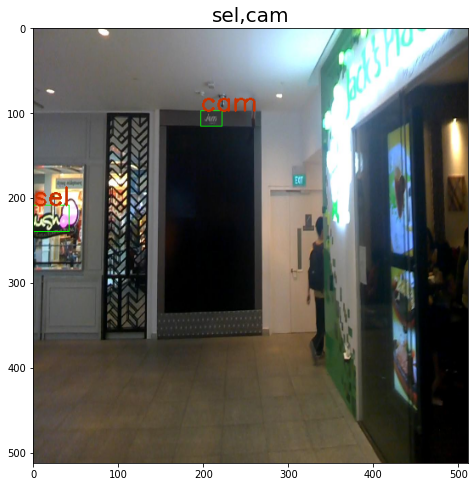

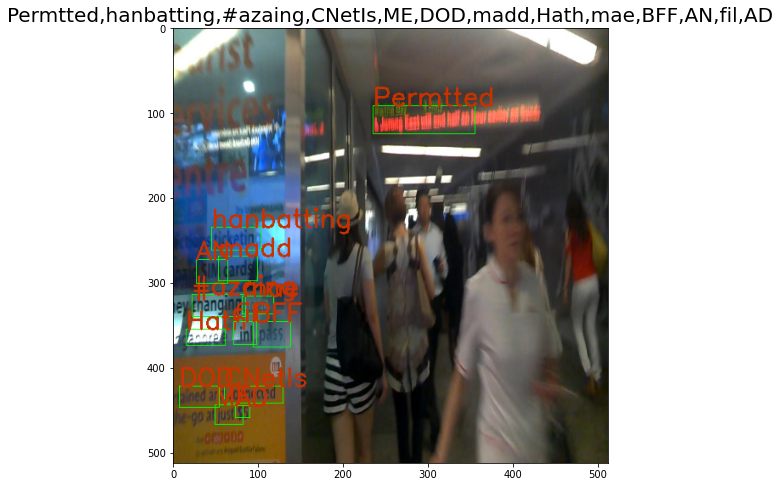

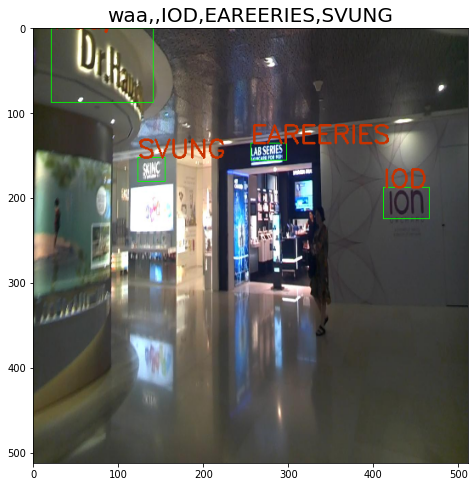

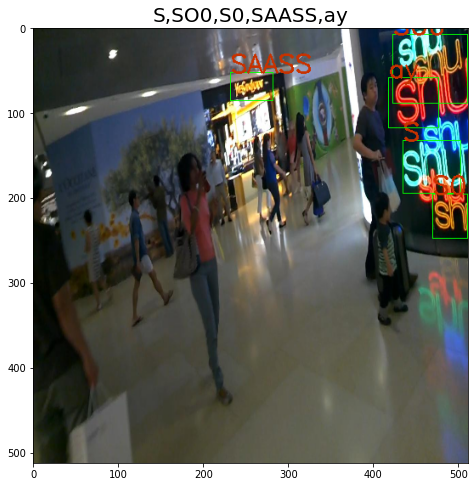

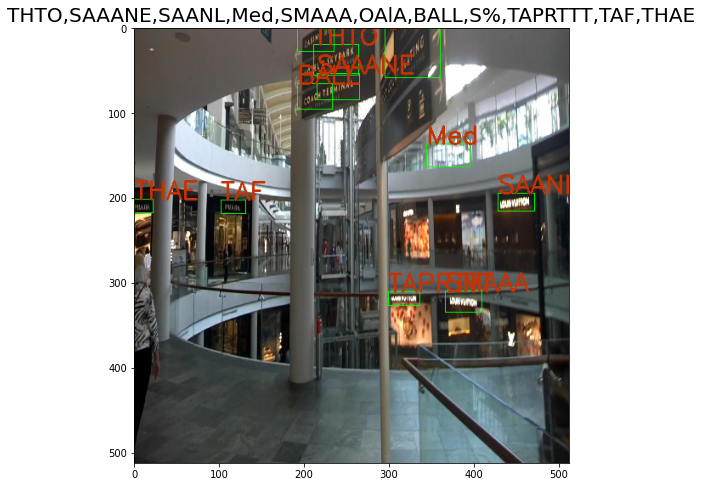

In [10]:
# Inference
paths = os.listdir('ch4_training_images')
index = np.arange(0, len(paths))
np.random.shuffle(index)
for i in index[:5]:
  path = 'ch4_training_images/' + paths[i]
  show_image(path)

As we can see, the detection model is performing barely good, but the recognition is not performing as expected. Its because of the use of less training data.